In [1]:
import dicom
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

from sklearn.model_selection import train_test_split
from dicom.contrib.pydicom_PIL import show_PIL
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [2]:
dirPath = '/enc_data/eddata/pacemaker'
dataPath = os.path.join(dirPath, 'organized-data')
allPatients = os.listdir(dataPath)
print('Number of patients: {}'.format(len(allPatients)))

Number of patients: 46022


### Build a data structure that stores the files for each patient and their clipnum

In [3]:
""" 
patientsFiles:
    patientID:
        clipnum: ['1065325/6132532-2206-09-09-0948-POSTERO-ANTERIOR.dcm']
        clipnum: []
"""
patientsFiles = {}

for i, patient in enumerate(allPatients):
    if i%10000 == 0: print(i)
        
    patientFiles = patientsFiles.setdefault(patient, {})
    
    files = os.listdir(os.path.join(dataPath, patient))
    for f in files:
        clipnum = f.split('-')[0]
        
        clipFiles = patientFiles.setdefault(clipnum, [])
        clipFiles.append(os.path.join(patient, f))

    # if f.endswith('.dcm') and 'LATERAL' not in f:
    # if f.endswith('.res'):

0
10000
20000
30000
40000


In [4]:
def show_dicom(f):
    print(f)
    ds = dicom.read_file(os.path.join(dataPath, f))
    ds.BitsAllocated = 16 # 16-bit allocation instead of 12-bit allocation
    plt.figure(figsize=[10,10])
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [5]:
## Read the patients that have pacemakers 
f = open(os.path.join(dirPath, "clipnum_with_pacemaker.txt"))
patientsPacemkr = f.read().strip().split('\n')
print("Number of patients with pacemaker: {}".format(len(patientsPacemkr)))

Number of patients with pacemaker: 86


In [6]:
pacemakerFiles_all = []
pacemakerFiles_dicom = []

count = 0
for f in patientsPacemkr:
    patient, clipnum = f.split('/')
    try:
        files = patientsFiles[patient][clipnum]
        pacemakerFiles_all += files
        pacemakerFiles_dicom += [f for f in files if f.endswith('.dcm') and 'LATERAL' not in f and 'CHEST' not in f]
    except:
        count += 1
        
print('Number of clipnums without file: {}'.format(count))
print('Number of total files: {}'.format(len(pacemakerFiles_all)))
print('Number of dicom  file: {}'.format(len(pacemakerFiles_dicom)))

Number of clipnums without file: 30
Number of total files: 117
Number of dicom  file: 56


# Generate dataset of whole xray images

In [7]:
def get_PIL(dataset):
    """ Converts dicom dataset file to PIL files that can be imported into Keras """
    
    def get_LUT_value(data, window, level):
        """Apply the RGB Look-Up Table for the given data and window/level value."""
        
        ##### UNSURE IF I CAN DO THIS #####
        if isinstance(window, list):
            window = window[0]
        if isinstance(level, list):
            level = level[0]
            
        return np.piecewise(data, 
            [data <= (level - 0.5 - (window-1)/2),
                data > (level - 0.5 + (window-1)/2)],
                [0, 255, lambda data: ((data - (level - 0.5))/(window-1) + 0.5)*(255-0)])

    image = get_LUT_value(dataset.pixel_array, dataset.WindowWidth, dataset.WindowCenter)
    im = PIL.Image.fromarray(image).convert('L') # Convert mode to L since LUT has only 256 values: http://www.pythonware.com/library/pil/handbook/image.htm

    return im

In [11]:
def getRatio(filename):
    ds = dicom.read_file(os.path.join(dataPath, f))
    img = get_PIL(ds)
    x = img_to_array(img) # this is a Numpy array with shape (3, 300, 300)
    ratio = x.shape[1]/float(x.shape[0])
    print('shape: {}, ratio: {}'.format(x.shape, ratio))
    return ratio

In [12]:
def loadDicom(filename):
    ds = dicom.read_file(os.path.join(dataPath, f))
    img = get_PIL(ds)
    x = img_to_array(img) # this is a Numpy array with shape (3, 300, 300)
    return x

In [9]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [13]:
ratios = [getRatio(f) for f in pacemakerFiles_dicom]

shape: (2544, 3056, 1), ratio: 1.20125786164
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (2540, 3056, 1), ratio: 1.2031496063
shape: (2540, 3056, 1), ratio: 1.2031496063
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (2791, 2488, 1), ratio: 0.891436761018
shape: (1949, 1774, 1), ratio: 0.910210364289
shape: (2544, 3056, 1), ratio: 1.20125786164
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (2544, 3056, 1), ratio: 1.20125786164
shape: (2544, 2866, 1), ratio: 1.12657232704
shape: (2472, 2544, 1), ratio: 1.02912621359
shape: (2791, 2488, 1), ratio: 0.891436761018
shape: (2544, 3056, 1), ratio: 1.20125786164
shape: (3056, 2544, 1), ratio: 0.83246073298

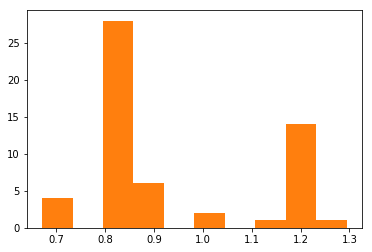

In [16]:
plt.hist(ratios)
plt.show()

In [10]:
x_True = [loadDicom(f) for f in pacemakerFiles_dicom]

shape: (2544, 3056, 1), ratio: 1.20125786164
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (2540, 3056, 1), ratio: 1.2031496063
shape: (2540, 3056, 1), ratio: 1.2031496063
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (2791, 2488, 1), ratio: 0.891436761018
shape: (1949, 1774, 1), ratio: 0.910210364289
shape: (2544, 3056, 1), ratio: 1.20125786164
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (3056, 2544, 1), ratio: 0.832460732984
shape: (2544, 3056, 1), ratio: 1.20125786164
shape: (2544, 2866, 1), ratio: 1.12657232704
shape: (2472, 2544, 1), ratio: 1.02912621359
shape: (2791, 2488, 1), ratio: 0.891436761018
shape: (2544, 3056, 1), ratio: 1.20125786164
shape: (3056, 2544, 1), ratio: 0.83246073298

In [82]:
noneFiles_dicom = set()
x_False = []

for patient in patientsFiles.keys()[:30]:
    for clipnum in patientsFiles[patient]:
        files = patientsFiles[patient][clipnum]
        
        for f in files:
            if not f.endswith('.dcm') or 'LATERAL' in f or 'CHEST' in f: continue
            # show_dicom(f)
            noneFiles_dicom.add(f)
            x_False.append(loadDicom(f))

((3056, 2544, 1), '839798/7044227-2186-04-06-1310-POSTERO-ANTERIOR.dcm', 0)
((3056, 2544, 1), '2062498/6620966-2190-02-01-1443-ANTERO-POSTERIOR.dcm', 0)
((3056, 2544, 1), '2978390/7605927-2180-09-04-1546-POSTERO-ANTERIOR.dcm', 0)
((3056, 2544, 1), '2978396/7605961-2174-09-26-1708-POSTERO-ANTERIOR.dcm', 0)
((3056, 2544, 1), '1770608/7301576-2189-11-16-0040-POSTERO-ANTERIOR.dcm', 0)
((3056, 2544, 1), '470928/7564251-2016-09-07-1227-ANTERO-POSTERIOR.dcm', 0)
((3056, 2544, 1), '470928/7564251-2140-08-10-1227-ANTERO-POSTERIOR.dcm', 0)
((3056, 2544, 1), '470928/6431754-2013-07-09-1216-POSTERO-ANTERIOR.dcm', 0)
((3056, 2544, 1), '470928/6431754-2137-06-11-1216-POSTERO-ANTERIOR.dcm', 0)
((3056, 2544, 1), '2309016/6377076-2188-05-30-1728-POSTERO-ANTERIOR.dcm', 0)
((3050, 2539, 1), '2457741/6532366-2184-10-18-0727-ANTERO-POSTERIOR.dcm', 0)
((2140, 1760, 1), '2457741/6675864-2185-03-25-1223-ANTERO-POSTERIOR.dcm', 0)
((2819, 2391, 1), '2457741/6681986-2185-03-31-1739-ANTERO-POSTERIOR.dcm', 0)
((27

In [44]:
# Check that there are no overlapping files between the two classes
set(pacemakerFiles_dicom) & noneFiles_dicom

set()

In [45]:
print(len(x_True), len(x_False))
y_True = [1]*len(x_True)
y_False = [0]*len(x_False)

(60, 78)


In [51]:
len(x_True)

60

In [54]:
X = np.array(x_True + x_False)
Y = np.array(y_True + y_False)
X.shape, Y.shape

((138,), (138,))